# Lab 5: House Candidate Positioning Graph Recreations

In this lab, we'll be recreating Figure 1 from this paper titled [Candidate Positioning in U.S. Elections](https://www-jstor-org.libproxy.berkeley.edu/stable/2669364?seq=1#metadata_info_tab_contents). The table we will be recreating shows the estimated issue positions of all Democrats and Republicans running for House positions in 2000 plotted against the conservatism of their district. We'll see that candidates tend to take positions according to the convervatism of their district with little deviation across party lines. 

Run the next cell to import the libraries we'll be using to do our analysis

In [72]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

Below, you'll find a chart containing labels of the columns in the dataset we'll be working with for this lab: 


| Variable | Meaning       |
|--------|------------------------|
| Gore    | % of candidate's district that voted for Gore in '00 |
| Bush '00     | % of candidate's district that voted for Bush in '00          |
| location   | candidate's state and district number               |
| first_name     | candidate's first name         |
| middle_name     | candidate's middle name         |  
| last_name     | candidate's last name      |  
| votes_with_party_pct    | % of times the candidate voted with their party in the previous Congressional session        |  
| votes_against_party_pct    | % of times the candidate voted against their party in the previous Congressional session           | 
| party    | candidate's party         | 
| Member Position    | 0-1 scale for how conservative a candidate's stances are (0=lowest conservative, 1=highest conservative)         | 

## Load Data

For our analysis, we'll be using district-level data on House members in the 106th Congress and their district behavior from the 2000 presidential election. 

We'll begin by loading our file housedata.csv into a pandas dataframe named df.

In [76]:
filename = "housedata.csv"
df = pd.read_csv(filename)
df

,State,Gore,Bush '00,location,first_name,middle_name,last_name,district,votes_with_party_pct,votes_against_party_pct,party,suffix,gender,geoid,Member Position
0,AK,0.28,0.59,AK1,Don,NaN,Young,1.0,0.92,0.0757,R,NaN,M,200.0,0.92
1,AL,0.38,0.60,AL1,Sonny,NaN,Callahan,1.0,0.94,0.0589,R,NaN,NaN,101.0,0.94
2,AL,0.38,0.61,AL2,Terry,NaN,Everett,2.0,0.95,0.0486,R,NaN,M,102.0,0.95
3,AL,0.47,0.52,AL3,Bob,NaN,Riley,3.0,0.93,0.0718,R,NaN,M,103.0,0.93
4,AL,0.37,0.61,AL4,Robert,B.,Aderholt,4.0,0.90,0.0986,R,NaN,M,104.0,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434,WI,0.43,0.52,WI8,Mark,A.,Green,8.0,0.91,0.0867,R,NaN,M,5508.0,0.91
435,WV,0.43,0.54,WV1,Alan,B.,Mollohan,1.0,0.82,0.1774,D,NaN,M,5401.0,0.18
436,WV,0.44,0.54,WV2,Robert,E.,Wise,2.0,0.86,0.1372,D,Jr.,M,5402.0,0.14
437,WV,0.51,0.47,WV3,Nick,J.,Rahall,3.0,0.86,0.1390,D,II,M,5403.0,0.14


## Cleaning Data

Before we can begin manipulating our data to recreate our table, we must first clean the data. The following cells will walk you through dropping unnecessary columns and removing null values that could disrupt our analysis. 

### Drop Columns

Since we are mainly interested in the voting patterns of the members and their districts, there are a few columns currently included in df that we can get rid of. First, we'll start with an example. Then, you'll get to write your own code to drop certain columns. 

Run the following cell to drop the "geoid" column:

In [74]:
#Example
df = df.drop(['State'], axis=1)
df

,Gore,Bush '00,location,first_name,middle_name,last_name,district,votes_with_party_pct,votes_against_party_pct,party,suffix,gender,geoid,Member Position
0,0.28,0.59,AK1,Don,NaN,Young,1.0,0.92,0.0757,R,NaN,M,200.0,0.92
1,0.38,0.60,AL1,Sonny,NaN,Callahan,1.0,0.94,0.0589,R,NaN,NaN,101.0,0.94
2,0.38,0.61,AL2,Terry,NaN,Everett,2.0,0.95,0.0486,R,NaN,M,102.0,0.95
3,0.47,0.52,AL3,Bob,NaN,Riley,3.0,0.93,0.0718,R,NaN,M,103.0,0.93
4,0.37,0.61,AL4,Robert,B.,Aderholt,4.0,0.90,0.0986,R,NaN,M,104.0,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434,0.43,0.52,WI8,Mark,A.,Green,8.0,0.91,0.0867,R,NaN,M,5508.0,0.91
435,0.43,0.54,WV1,Alan,B.,Mollohan,1.0,0.82,0.1774,D,NaN,M,5401.0,0.18
436,0.44,0.54,WV2,Robert,E.,Wise,2.0,0.86,0.1372,D,Jr.,M,5402.0,0.14
437,0.51,0.47,WV3,Nick,J.,Rahall,3.0,0.86,0.1390,D,II,M,5403.0,0.14


Now it's your turn! In the following cell, write some code that drops the following columns: suffix, gender, geoid, district

In [75]:
#Use this cell to drop the specified columns
#...
df = df.drop(['suffix', 'gender', 'geoid', 'district'], axis=1)
df

,Gore,Bush '00,location,first_name,middle_name,last_name,votes_with_party_pct,votes_against_party_pct,party,Member Position
0,0.28,0.59,AK1,Don,NaN,Young,0.92,0.0757,R,0.92
1,0.38,0.60,AL1,Sonny,NaN,Callahan,0.94,0.0589,R,0.94
2,0.38,0.61,AL2,Terry,NaN,Everett,0.95,0.0486,R,0.95
3,0.47,0.52,AL3,Bob,NaN,Riley,0.93,0.0718,R,0.93
4,0.37,0.61,AL4,Robert,B.,Aderholt,0.90,0.0986,R,0.90
...,...,...,...,...,...,...,...,...,...,...
434,0.43,0.52,WI8,Mark,A.,Green,0.91,0.0867,R,0.91
435,0.43,0.54,WV1,Alan,B.,Mollohan,0.82,0.1774,D,0.18
436,0.44,0.54,WV2,Robert,E.,Wise,0.86,0.1372,D,0.14
437,0.51,0.47,WV3,Nick,J.,Rahall,0.86,0.1390,D,0.14


Great job! You have successfully dropped all unneeded columns.

### Removing Null Values

Taking a look at the dataset, we'll see that some rows contain "NaN" in the last_name column. For the purpose of our analysis, we want to exclude these rows because they can disrupt what we are able to do with the data. 

The following cell provides an example for how you can drop rows containing "NaN" in the first_name column.

In [65]:
#Example
df.dropna(subset=['first_name'])

,Gore,Bush '00,location,first_name,middle_name,last_name,district,votes_with_party_pct,votes_against_party_pct,party,Member Position
0,0.28,0.59,AK1,Don,NaN,Young,1.0,0.92,0.0757,R,0.92
1,0.38,0.60,AL1,Sonny,NaN,Callahan,1.0,0.94,0.0589,R,0.94
2,0.38,0.61,AL2,Terry,NaN,Everett,2.0,0.95,0.0486,R,0.95
3,0.47,0.52,AL3,Bob,NaN,Riley,3.0,0.93,0.0718,R,0.93
4,0.37,0.61,AL4,Robert,B.,Aderholt,4.0,0.90,0.0986,R,0.90
...,...,...,...,...,...,...,...,...,...,...,...
434,0.43,0.52,WI8,Mark,A.,Green,8.0,0.91,0.0867,R,0.91
435,0.43,0.54,WV1,Alan,B.,Mollohan,1.0,0.82,0.1774,D,0.18
436,0.44,0.54,WV2,Robert,E.,Wise,2.0,0.86,0.1372,D,0.14
437,0.51,0.47,WV3,Nick,J.,Rahall,3.0,0.86,0.1390,D,0.14


Now it's your turn! Write some code that will drop rows containing "NaN" in the last_name column.

In [66]:
#Use this cell to drop rows in the last_name column containing "NaN"
#df = ...
#df
df = df.dropna(subset=['last_name'])
df

,Gore,Bush '00,location,first_name,middle_name,last_name,district,votes_with_party_pct,votes_against_party_pct,party,Member Position
0,0.28,0.59,AK1,Don,NaN,Young,1.0,0.92,0.0757,R,0.92
1,0.38,0.60,AL1,Sonny,NaN,Callahan,1.0,0.94,0.0589,R,0.94
2,0.38,0.61,AL2,Terry,NaN,Everett,2.0,0.95,0.0486,R,0.95
3,0.47,0.52,AL3,Bob,NaN,Riley,3.0,0.93,0.0718,R,0.93
4,0.37,0.61,AL4,Robert,B.,Aderholt,4.0,0.90,0.0986,R,0.90
...,...,...,...,...,...,...,...,...,...,...,...
434,0.43,0.52,WI8,Mark,A.,Green,8.0,0.91,0.0867,R,0.91
435,0.43,0.54,WV1,Alan,B.,Mollohan,1.0,0.82,0.1774,D,0.18
436,0.44,0.54,WV2,Robert,E.,Wise,2.0,0.86,0.1372,D,0.14
437,0.51,0.47,WV3,Nick,J.,Rahall,3.0,0.86,0.1390,D,0.14


## Graphing the Data

This section will walk you through how to create a scatterplot and fit linear regressions to our data. 

Democratic slope: 0.15687461066120845
Republican slope: 0.13827041986315086


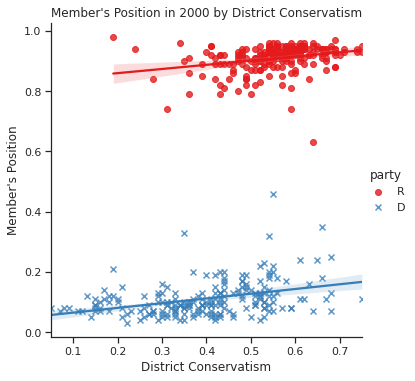

In [68]:
#Graphing the scatterplot
sns.lmplot(x="Bush '00", y='Member Position', hue="party", 
           data=df,markers=["o", "x"], palette="Set1")

#Adjusting scatterplot labels
sns.set(style='ticks')
plt.xlabel("District Conservatism")
plt.ylabel("Member's Position")
plt.title("Member's Position in 2000 by District Conservatism")
print("Democratic slope: " + str(d.slope))
print("Republican slope: " + str(r.slope))

### Observations

Now that we've successfully recreated the graph, it's time to make some observations and inferences based on what we see. Pleasee write a brief 1-2 sentence answer for each of the following questions:

1. Interpret the slopes of the regressions for the Republican data clump and the Democrat data clump. No need to get too specific mathmatically, just observe the general trend and think about what it suggests about the relationship between candidate's position taking and their district's political leanings. 

*Question 1 answer here*

2. Politically, why might we see the trends displayed in the graph?

*Question 2 answer here*

## The End

Congratulations! You have finished this lab on House candidate positioning.